In [243]:
from __future__ import print_function
import os
data_path = [ 'data']

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [244]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['train.csv'])
data = pd.read_csv(filepath, sep=',')


#### 1. 데이터 전처리:
- 이름 데이터에서 브랜드 이름 빼내기
- 단위가 있는 object 데이터 단위 제거하고 float으로 치환
- missing data 처리
- object 데이터 one hot encoding
- target값을 int형으로 치환
- 소수 둘째자리까지 데이터가 존재하므로 100을 곱하고 int형으로 치환


In [245]:
data.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

In [246]:
## Name feature에서 브랜드명만 추출하고 drop한다.
data["Brand"] = data['Name'].str.split().str[0]
data.drop('Name', axis = 1, inplace= True)
data['Brand'].value_counts()

## New_Price행의 경우, 결측값이 너무 많으므로 drop한다.
data.drop('New_Price', axis = 1, inplace= True)
data.head(1).T

,0
Location,Mumbai
Year,2010
Kilometers_Driven,72000
Fuel_Type,CNG
Transmission,Manual
Owner_Type,First
Mileage,26.6 km/kg
Engine,998 CC
Power,58.16 bhp
Seats,5.0


In [247]:
## 해당 feature들의 단위를 분리한다. 
## Power의 경우 null bps라는 데이터가 존재하므로, 해당 데이터를 Nan으로 바꾸어준다.

unit_labels = ['Mileage', 'Engine', 'Power']
for i in unit_labels:
    data[i] = data[i].str.split().str[0]
    data[i] = data[i].apply(lambda x: None if x == 'null' else x)
    data[i] = data[i].astype(float)

print(data[unit_labels].isna().sum())


Mileage      2
Engine      36
Power      143
dtype: int64


In [248]:
data.isna().sum()

Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
Brand                  0
dtype: int64

In [249]:
## 결측 값에 해당 feature의 평균값을 넣어준다.
nan_labels = ['Mileage','Engine','Power','Seats']
idx = data[data['Seats'].isnull()].head(1).index[0]
print(data.loc[idx].T)

for i in nan_labels:
    data[i].fillna(data[i].mean(), inplace= True)

print(data.loc[idx].T)
data.isna().sum()

Location             Ahmedabad
Year                      2007
Kilometers_Driven        60006
Fuel_Type               Petrol
Transmission            Manual
Owner_Type               First
Mileage                    0.0
Engine                     NaN
Power                      NaN
Seats                      NaN
Price                     2.95
Brand                    Honda
Name: 194, dtype: object
Location              Ahmedabad
Year                       2007
Kilometers_Driven         60006
Fuel_Type                Petrol
Transmission             Manual
Owner_Type                First
Mileage                     0.0
Engine               1621.27645
Power                 113.25305
Seats                  5.278735
Price                      2.95
Brand                     Honda
Name: 194, dtype: object


Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
dtype: int64

In [250]:
## categorical feature를 one hot encoding 한다.
cate_labels = data.select_dtypes(object).columns

for i in cate_labels:
    data[i] = pd.Categorical(data[i])

data = pd.get_dummies(data, columns= cate_labels)
data.head(1).T

,0
Year,2010.00
Kilometers_Driven,72000.00
Mileage,26.60
Engine,998.00
Power,58.16
Seats,5.00
Price,1.75
Location_Ahmedabad,0.00
Location_Bangalore,0.00
Location_Chennai,0.00


In [251]:
CATEGORIZE_RANGE = 1
def categorize(value):
    return int(value) // CATEGORIZE_RANGE

In [252]:
#소수 둘째짜리 기준.
def float_to_int(value):
    return int(value) * 100

In [253]:
## Price값을 int형으로 바꾼다.
print(data['Price'].max())
print(data['Price'].min())

#data['Price'] = data['Price'].map(categorize)
# float형을 그대로 반영하는 경우 윗 줄을 주석처리하고, 아래 주석을 지워주세요
data['Price'] = data['Price'].map(float_to_int)

160.0
0.44


#### 2.데이터 분석

In [254]:
target = 'Price'
fields = data.columns.tolist()
fields.remove(target)
correlations = abs(data[fields].corrwith(data[target]))
correlations.sort_values(inplace=True)
correlations.tail(10)

Brand_BMW                 0.303518
Year                      0.303997
Mileage                   0.307301
Fuel_Type_Petrol          0.309371
Fuel_Type_Diesel          0.320592
Brand_Mercedes-Benz       0.366583
Transmission_Manual       0.586183
Transmission_Automatic    0.586183
Engine                    0.657567
Power                     0.767531
dtype: float64

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

#sns.pairplot(data, hue= 'color')

[(-1.0, 1.0), Text(0, 0.5, 'correlation')]

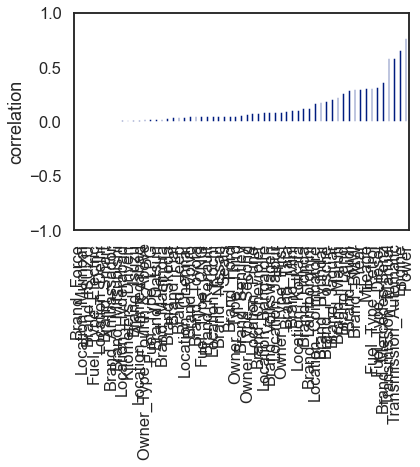

In [256]:
ax = correlations.plot(kind='bar')
ax.set(ylim = [-1, 1], ylabel= 'correlation')

#### 3.결과

In [257]:
## estimator은 넣기전에 반드시 fit을 진행해야함!
## 단순 복붙한 코드임
def plot_decision_boundary(estimator, X, y):
    X_color = X.sample(300)
    y_color = y.loc[X_color.index]
    y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
    x_axis, y_axis = np.arange(0, 1, .005), np.arange(0, 1, .005)
    xx, yy = np.meshgrid(x_axis, y_axis)
    xx_ravel = xx.ravel()
    yy_ravel = yy.ravel()
    X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
    y_grid_predictions = estimator.predict(X_grid)
    y_grid_predictions = y_grid_predictions.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
    ax.scatter(X_color.iloc[:, 0], X_color.iloc[:, 1], color=y_color, alpha=1)
    ax.set(
        xlabel=fields[0],
        ylabel=fields[1],
        title=str(estimator))

In [258]:
scaled_data = data.copy()
feature_cols = correlations.iloc[-10:].index
scaler = MinMaxScaler()

scaled_data[feature_cols] = scaler.fit_transform(data[feature_cols])

train, test = train_test_split(scaled_data, test_size=0.3, random_state=42)

X_train = train[feature_cols]
y_train = train[target]
X_test = test[feature_cols]
y_test = test[target]

LSCV = LinearSVC()
LSCV.fit(X_train, y_train)

mean_squared_error(y_train,LSCV.predict(X_train))

954478.9935912652

In [259]:
mean_squared_error(y_test,LSCV.predict(X_test))

1091932.4473975636

#### 4. 결과분석 (correlation이 높은 데이터 2개만 사용하였음)
##### target feature에 기존 float data를 int형으로 치환하여 사용한 경우
- 실수 데이터가 소수 둘째자리까지 존재하여, 100을 곱하여 int형으로 바꾸어 전처리하였음.
- 오류율이 매우매우매우매우 크게 나옴 (853127.4330011074)
- categorical target을 예측하는 모델이기에 이런 결과를 보이는 듯 함.

##### 임의로 categorize한 feature를 사용한 경우
- 데이터의 소숫점을 버리고, 임의의 수로 몫연산을 진행함
- ex) 24.55 -> 24 // 5(임의의 수) = 4
- categorize하는 범위에 따라 오류율이 달랐음
- 나누는 범위가 좁으면 (임의의 수가 작을 수록) 좁을수록 오류율이 증가함

#### 5. 결론
##### DT
- 해당 데이터의 오류율이 가장 낮게 나왔다.
- 우리의 데이터가 전체 데이터에 비해 categorical data의 비율이 높았고, DT의 경우 이를 잘 처리할 수 있기 때문에 좋은 결과가 나온 것 같다.
##### NB
- 3번째로 좋은 성능을 보여주었다.
- DT, NN에 비해 낮은 성능을 보인 까닭은 우리의 데이터의 feature들간에 종속성이 존재하기 때문이라고 생각된다.
- 예를 들어, 연료 타입과 자동차의 마력은 종속성이 존재할 가능성이 매우 크다.
- 따라서 종속성을 완전히 배재할 수 없는 우리 데이터의 특성상, NB는 최적의 알고리즘이 아니라고 생각된다. 
##### SVM
- 가장 안좋은 성능을 보였다.
- 그 이유를 짐작하자면, target data를 임의의 int데이터로 변환해야하였고, 이 때문에 원하는 데이터가 나오지 않을 수 있을 가능성이 크기 때문이다.
- 이에 대한 근거로, float data를 그대로 반영하였을 때, 오류율이 굉장히 크게 나왔다. (853127.4330011074)
- 따라서 target data가 실수형인 해당 데이터에서, SVM은 적합하지 않다고 생각된다.

##### 최적 알고리즘
- 우리 데이터의 최적 알고리즘은 DT다.